# Segmentação de Clientes E-commerce (RFM + K-Means)

## Objetivo
Agrupar os clientes do e-commerce de acordo com seu comportamento de compra para direcionar estratégias de marketing personalizadas.

## Metodologia
1. **Análise RFM**: Extração e processamento dos pilares de Recência (R), Frequência e Valor Monetário (M) via SQL e Pandas.
2. **Normalização de Dados**: Utilização do `StandardScaler` para garantir que as diferentes escalas não enviesem o modelo.
3. **Clusterização com K-Means**: Utilização de aprendizado não supervisionado para identificar agrupamentos naturais de clientes com comportamentos similares.

---


In [ ]:
# Imports e conexão

import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('../ecommerce_brasil.db')

query = """
SELECT
    c.Customer_Id,
    o.Order_Date,
    o.Total
    FROM orders o
    JOIN customers c ON o.Id = c.Id
"""

df =pd.read_sql(query, conn)

In [3]:
# Cálculo do RFM

df['Order_Date'] = pd.to_datetime(df['Order_Date'])

data_hoje = df['Order_Date'].max() + pd.Timedelta(days=1)

# Criando a tabela RFM
df_rfm = df.groupby('Customer_Id').agg({
    'Order_Date': lambda x: (data_hoje - x.max()).days,
    'Customer_Id': 'count',
    'Total': 'sum'
}).rename(columns={
    'Order_Date': 'Recencia',
    'Customer_Id': 'Frequencia',
    'Total': 'Monetario'
}).reset_index()

print("--- Primeiras linhas do RFM ---")
print(df_rfm.head())

print("\n--- Estatísticas Descritivas ---")
print(df_rfm.describe())

--- Primeiras linhas do RFM ---
  Customer_Id  Recencia  Frequencia  Monetario
0      C00001        36           1    3586.28
1      C00002        13           1    1636.64
2      C00003        20           1    2019.82
3      C00004        38           1     237.23
4      C00005         5           1     193.33

--- Estatísticas Descritivas ---
          Recencia  Frequencia     Monetario
count  2000.000000      2000.0   2000.000000
mean     46.581500         1.0   2502.084065
std      25.446633         0.0   3230.077787
min       1.000000         1.0     38.540000
25%      25.000000         1.0    250.520000
50%      47.000000         1.0   1220.790000
75%      68.000000         1.0   3478.402500
max      90.000000         1.0  18349.540000


### Análise dos dados
* **Frequência Constante**: A frequência é exatamente 1.0 para todos os clientes (desvio padrão zero), ou seja, neste dataset específico, não há compras recorrentes. Isso era algo esperado para este dataset.
* **Recência Variada**: Os clientes variam de 1 a 90 dias sem comprar, com uma média de 46 dias.
* **Monetário Discrepante**: Temos clientes que gastaram R$ 38,54 e outros que gastaram R$ 18.349,54. O desvio padrão é bem alto (R$ 3.230), o que é ótimo para o K-Means encontrar grupos distintos.

Como a frequência é igual para todos, o **K-Means** vai focar apenas em Recência e Valor, o que é comum em datasets menores.

In [11]:
# Scaling
X = df_rfm[['Recencia', 'Monetario']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treino do modelo
model = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rfm['Cluster'] = model.fit_predict(X_scaled)

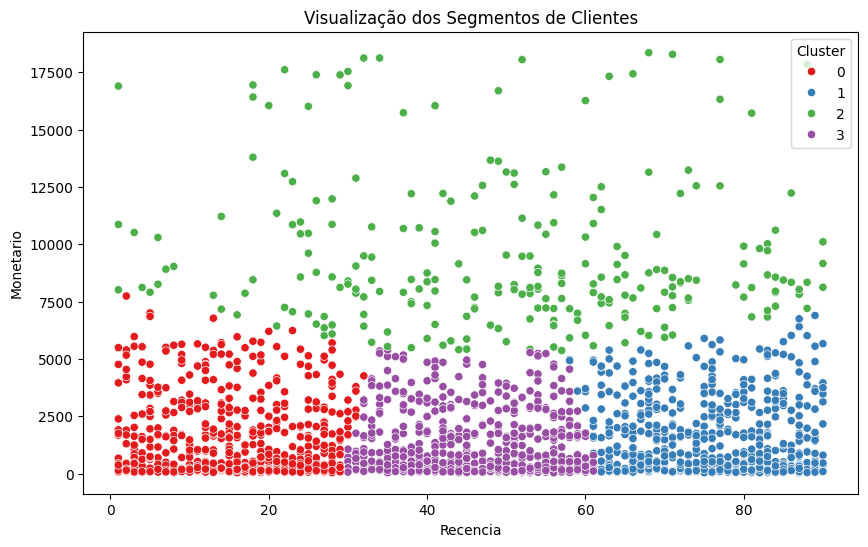

,Recencia,Monetario,Cluster
Cluster,,,
2,50.019920,9458.868606,251
0,15.366726,1658.932630,559
1,75.764007,1614.693565,589
3,45.579035,1250.572812,601


In [12]:
# Visualização dos resultados
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_rfm, x='Recencia', y='Monetario', hue='Cluster', palette='Set1')
plt.title("Visualização dos Segmentos de Clientes")
plt.show()

df_rfm.groupby('Cluster').agg({
    'Recencia': 'mean',
    'Monetario': 'mean',
    'Cluster': 'count'
}).sort_values('Monetario', ascending=False)

### Otimizando o modelo
O resultado obtido está bom, porém podemos buscar o número ideal de _clusters_ atravésdo **Método do Cotovelo (Elbow Method)**.

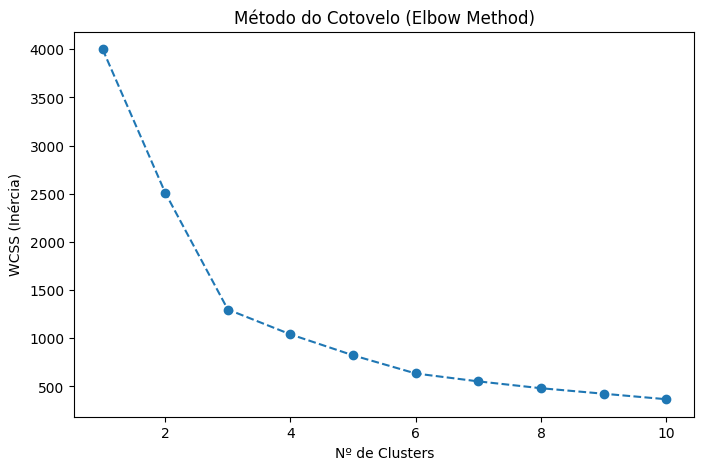

In [13]:
wcss = []

for i in range(1,11):
    kmeans_test = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    wcss.append(kmeans_test.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Nº de Clusters')
plt.ylabel('WCSS (Inércia)')
plt.show()